# Setting up

Before starting, we need to download the model weights for TamGen. This might take a while... Just run the cells below to get started

Instructions for manual install:

Download link:
https://zenodo.org/records/13751391

- Download the checkpoints and extract them in the root folder
- Copy 'checkpoints/crossdocked_model/checkpoint_best.pt' and place it in the 'gpt_model' model

In [ ]:
!wget -nc https://zenodo.org/records/13751391/files/checkpoints.zip

In [ ]:
!unzip checkpoints.zip -d ./

In [ ]:
!cp ./checkpoints/crossdocked_model/checkpoint_best.pt ./gpt_model/

# Pre-Processing

We create a KG in NetworkX-arangoDB

This requires downloading multi-modality datasets from [Bio Snap](https://snap.stanford.edu/biodata/) and other data source. This notebook does simple data engineering before pushing into ArangoDB to create a fully connected network.

##### Modalities:
- Drug-Drug interaction with side-effects
- Drug-Gene interaction
- Disease-Drug interaction
- Disease-Disease interaction
- Disease-Function interaction
- Function-Function interaction
- Gene-Function interaction
- Gene-Gene interaction
- Gene-Protien interaction
- Genomic Region-Genomic Region interaction
- Protien-Protien interaction
- Protien-Protien-Tissue interaction
- Tissue-Function-Gene interaction

In [6]:
# Interactions
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10002/files/ChG-Miner_miner-chem-gene.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10004/files/DCh-Miner_miner-disease-chemical.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10006/files/DD-Miner_miner-disease-disease.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10019/files/DF-Miner_miner-disease-function.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10020/files/DG-Miner_miner-disease-gene.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10026/files/FF-Miner_miner-func-func.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10024/files/GF-Miner_miner-gene-function.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10027/files/GP-Miner_miner-gene-protein.tsv.gz

# Mappings
!wget -nc -P ./data/ https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_35_chemreps.txt.gz

# Entities and Feature tables
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10021/files/D-DoMiner_miner-diseaseDOID.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10003/files/D-MeshMiner_miner-disease.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10025/files/D-OmimMiner_miner-diseaseOMIM.tsv.gz
!wget -nc -P ./data/ https://snap.stanford.edu/biodata/datasets/10022/files/G-SynMiner_miner-geneHUGO.tsv.gz


File ‘./data/ChCh-Miner_durgbank-chem-chem.tsv.gz’ already there; not retrieving.

File ‘./data/ChG-Miner_miner-chem-gene.tsv.gz’ already there; not retrieving.

File ‘./data/DCh-Miner_miner-disease-chemical.tsv.gz’ already there; not retrieving.

File ‘./data/DD-Miner_miner-disease-disease.tsv.gz’ already there; not retrieving.

File ‘./data/DF-Miner_miner-disease-function.tsv.gz’ already there; not retrieving.

File ‘./data/DG-Miner_miner-disease-gene.tsv.gz’ already there; not retrieving.

File ‘./data/FF-Miner_miner-func-func.tsv.gz’ already there; not retrieving.

File ‘./data/GF-Miner_miner-gene-function.tsv.gz’ already there; not retrieving.

File ‘./data/GP-Miner_miner-gene-protein.tsv.gz’ already there; not retrieving.

File ‘./data/chembl_35_chemreps.txt.gz’ already there; not retrieving.

File ‘./data/D-DoMiner_miner-diseaseDOID.tsv.gz’ already there; not retrieving.

File ‘./data/D-MeshMiner_miner-disease.tsv.gz’ already there; not retrieving.

File ‘./data/D-OmimMiner_mine

In [20]:
import os
import sys
import requests
import ast
import json
import hashlib
from datetime import datetime
from glob import glob
from io import StringIO
import boto3

import pandas as pd
import numpy as np

from dotenv import load_dotenv
from arango import ArangoClient
from biomart import BiomartServer

from transformers import AutoTokenizer, AutoModel
import torch

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain.llms.bedrock import Bedrock
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

from DeepPurpose import utils
from DeepPurpose import DTI as models

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw, AllChem

from Bio.PDB import MMCIFParser

import faiss

### Loading Dataset

#### Entities and Feature Tables

In [8]:
# Disease DOID Synopses

Doid = pd.read_csv(
    "./data/D-DoMiner_miner-diseaseDOID.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["doid", "name", "definition", "synonym"],
)

Doid

,doid,name,definition,synonym
0,DOID:0001816,angiosarcoma,A malignant vascular tumor that results_in rap...,hemangiosarcoma EXACT []
1,DOID:0002116,pterygium,NaN,surfer's eye EXACT []
2,DOID:0014667,disease of metabolism,A disease that involving errors in metabolic p...,metabolic disease EXACT [SNOMEDCT_2005_07_31:...
3,DOID:0050001,Actinomadura madurae infectious disease,NaN,NaN
4,DOID:0050002,Actinomadura pelletieri infectious disease,NaN,NaN
...,...,...,...,...
9242,DOID:9989,metastasis to the orbit,NaN,secondary malignant neoplasm of orbit (disorde...
9243,DOID:999,eosinophilia,NaN,Eosinophilic leukocytosis EXACT [MTHICD9_2006:...
9244,DOID:9993,hypoglycemia,NaN,Hypoglycaemia EXACT [SNOMEDCT_2005_07_31:15469...
9245,DOID:9995,endocrine and metabolic disturbances specific ...,NaN,NaN


In [9]:
# Disease MESH Synopses

Mesh = pd.read_csv(
    "./data/D-MeshMiner_miner-disease.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["mesh", "name", "definition", "synonym"],
)

Mesh

,mesh,name,definition,synonym
0,MESH:C538288,10p Deletion Syndrome (Partial),NaN,"Chromosome 10, 10p- Partial|Chromosome 10, mon..."
1,MESH:C535484,13q deletion syndrome,NaN,Chromosome 13q deletion|Chromosome 13q deletio...
2,MESH:C579849,15q24 Microdeletion,NaN,15q24 Deletion|15q24 Microdeletion Syndrome|In...
3,MESH:C579850,16p11.2 Deletion Syndrome,NaN,NaN
4,MESH:C567076,"17,20-Lyase Deficiency, Isolated",NaN,"17-Alpha-Hydroxylase-17,20-Lyase Deficiency, C..."
...,...,...,...,...
11327,MESH:C536729,Zunich neuroectodermal syndrome,NaN,CHIME syndrome
11328,MESH:C536730,Zuska's Disease,NaN,Lactation and squamous metaplasia of lactifero...
11329,MESH:C565223,Zygodactyly 1,NaN,ZD1
11330,MESH:D015051,Zygomatic Fractures,Fractures of the zygoma.,"Fractures, Zygomatic|Fracture, Zygomatic|Zygom..."


In [10]:
# OMIM Genetic Disorders

Omim = pd.read_csv(
    "./data/D-OmimMiner_miner-diseaseOMIM.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["omim", "phenotypes", "gene_name", "gene", "location", "_"],
)

Omim = Omim.iloc[:, :-1]

Omim

,omim,phenotypes,gene_name,gene,location
0,OMIM:115665,"Cataract 8, multiple types (2)","Cataract, congenital, Volkmann type","CTRCT8, CCV",1pter-p36.13
1,OMIM:607671,"Dystonia 13, torsion (2)","Dystonia 13, torsion",DYT13,1p36.32-p36.13
2,OMIM:606242,Kondoh syndrome (2),"Kondoh syndrome (mental retardation, microceph...",KONDS,1p36.32-p35.3
3,OMIM:614414,"Deafness, autosomal recessive 96 (2)","Deafness, autosomal recessive 96",DFNB96,1p36.31-p36.13
4,OMIM:609918,Gallbladder disease 2 (2),Gallbladder disease 2,GBD2,1p36.21
...,...,...,...,...,...
1186,OMIM:300519,"Mental retardation, X-linked, syndromic, Marti...","Mental retardation, X-linked, syndromic, Marti...",MRXSMP,Chr.X
1187,OMIM:400042,"Spermatogenic failure, Y-linked, 1 (4)",Chromosome Yq11 interstitial deletion syndrome,"DELYq11, CYDELq11, SPGFY1",Yq11
1188,OMIM:475000,NaN,"Growth control, Y-chromosome influenced","GCY, TSY, STA",Yq12
1189,OMIM:400043,"Deafness, Y-linked 1 (1)","Deafness, Y-linked 1",DFNY1,Chr.Y


In [11]:
# Gene

Gene = pd.read_csv(
    "./data/G-SynMiner_miner-geneHUGO.tsv.gz",
    compression="gzip",
    sep="\t",
)

Gene = Gene.rename(columns={'# ensembl_gene_id': 'ensg', 'symbol': 'gene', 'name': 'gene_name'})

Gene

/var/folders/xb/gzq2kh212g9g01hg900w3y1r0000gn/T/ipykernel_55882/2109625620.py:3: DtypeWarning: Columns (32,34,38) have mixed types. Specify dtype option on import or set low_memory=False.
  Gene = pd.read_csv(


,ensg,hgnc_id,gene,gene_name,locus_group,locus_type,status,location,location_sortable,alias_symbol,...,horde_id,merops,imgt,iuphar,kznf_gene_catalog,mamit-trnadb,cd,lncrnadb,enzyme_id,intermediate_filament_db
0,ENSG00000121410,HGNC:5,A1BG,alpha-1-B glycoprotein,protein-coding gene,gene with protein product,Approved,19q13.43,19q13.43,NaN,...,NaN,I43.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000268895,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,19q13.43,19q13.43,FLJ23569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000148584,HGNC:24086,A1CF,APOBEC1 complementation factor,protein-coding gene,gene with protein product,Approved,10q21.1,10q21.1,ACF|ASP|ACF64|ACF65|APOBEC1CF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000175899,HGNC:7,A2M,alpha-2-macroglobulin,protein-coding gene,gene with protein product,Approved,12p13.31,12p13.31,FWP007|S863-7|CPAMD5,...,NaN,I39.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000245105,HGNC:27057,A2M-AS1,A2M antisense RNA 1 (head to head),non-coding RNA,"RNA, long non-coding",Approved,12p13.31,12p13.31,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35649,ENSG00000162378,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",protein-coding gene,gene with protein product,Approved,1p32.3,01p32.3,FLJ13456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35650,ENSG00000159840,HGNC:13200,ZYX,zyxin,protein-coding gene,gene with protein product,Approved,7q32,07q32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35651,ENSG00000274572,HGNC:51695,ZYXP1,zyxin pseudogene 1,pseudogene,pseudogene,Approved,8q24.23,08q24.23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35652,ENSG00000074755,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,protein-coding gene,gene with protein product,Approved,17p13.3,17p13.3,KIAA0399|ZZZ4|FLJ10821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

def get_chemberta_embedding(smiles):
    """Generate a ChemBERTa embedding for a molecule, ensuring input is a string."""
    if not isinstance(smiles, str) or not smiles.strip():
        return None 

    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).tolist()[0]

This script processes DrugBank and ChEMBL chemical data to generate molecular embeddings using a ChemBERTa model. The final dataset contains drugs with their molecular representations and corresponding vector embeddings.

In [13]:
# DrugBank

DrugBank = pd.read_csv(
    "./data/drugbank_all_drugbank_vocabulary.csv.zip",
    compression="zip",
    sep=",",
    header=0,
    names=["drug", "accession", "drug_name", "cas", "unii", "synonym", "key"],
    dtype={"smiles": str}
)

ChemRepresentation = pd.read_csv(
    "./data/chembl_35_chemreps.txt.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["chembl", "smiles", "inchi", "key"],
)

Drug = DrugBank.merge(ChemRepresentation, on="key", how="inner")
Drug = Drug.dropna(subset=["smiles"])
Drug["smiles"] = Drug["smiles"].astype(str).str.strip()
Drug["generated"] = False

embeddings = []
for index, row in Drug.iterrows():
    smiles = row["smiles"]
    embedding = get_chemberta_embedding(smiles)
    embeddings.append(embedding)

Drug["embedding"] = embeddings

Drug


,drug,accession,drug_name,cas,unii,synonym,key,chembl,smiles,inchi,generated,embedding
0,DB00014,BTD00113 | BIOD00113,Goserelin,65807-02-5,0F65R8P09N,Goserelin | Goserelina,BLCLNMBMMGCOAS-URPVMXJPSA-N,CHEMBL1201247,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,False,"[0.26175203919410706, 0.019564686343073845, -0..."
1,DB00027,BTD00036 | BIOD00036,Gramicidin D,1405-97-6,5IE62321P4,Bacillus brevis gramicidin D | Gramicidin | Gr...,NDAYQJDHGXTBJL-MWWSRJDJSA-N,CHEMBL557217,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,False,"[0.505556583404541, 0.0775429829955101, -0.058..."
2,DB00035,BTD00112 | BTD00061 | BIOD00112 | BIOD00061,Desmopressin,16679-58-6,ENR1LLB0FP,1-(3-mercaptopropionic acid)-8-D-arginine-vaso...,NFLWUMRGJYTJIN-PNIOQBSNSA-N,CHEMBL1429,N=C(N)NCCC[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]...,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,False,"[0.1573418825864792, -0.010056326165795326, -0..."
3,DB00050,BTD00115 | APRD00686 | BIOD00115,Cetrorelix,120287-85-6,OON1HFZ4BA,Cetrorelix | Cetrorelixum,SBNPWPIBESPSIF-MHWMIDJBSA-N,CHEMBL1200490,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...,False,"[0.24220487475395203, 0.14190606772899628, -0...."
4,DB00080,BTD00111 | BIOD00111,Daptomycin,103060-53-3,NWQ5N31VKK,Daptomicina | Daptomycin | Daptomycine | Dapto...,DOAKLVKFURWEDJ-QCMAZARJSA-N,CHEMBL4744444,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N...,InChI=1S/C72H101N17O26/c1-5-6-7-8-9-10-11-22-5...,False,"[0.40401849150657654, 0.11877013742923737, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
8990,DB19419,NaN,Azadirachtin,11141-17-6,O4U1SAF85H,Azadirachtin a | Azatin | Biosal | Ecozin | Gr...,FTNJWQUOZFUQQJ-NDAWSKJSSA-N,CHEMBL509309,C/C=C(\C)C(=O)O[C@H]1C[C@@H](OC(C)=O)[C@@]2(C(...,InChI=1S/C35H44O16/c1-8-15(2)24(38)49-18-12-19...,False,"[0.6458231210708618, 0.2620610296726227, -0.11..."
8991,DB19436,NaN,L-lysyl-l-arginine,29586-66-1,HX25W9VLX3,"(2s)-2-(((2s)-2,6-bis(azanyl)hexanoyl)amino)-5...",NPBGTPKLVJEOBE-IUCAKERBSA-N,CHEMBL380183,NCCCC[C@H](N)C(=O)N[C@@H](CCCN=C(N)N)C(=O)O,InChI=1S/C12H26N6O3/c13-6-2-1-4-8(14)10(19)18-...,False,"[0.288204163312912, 0.22193492949008942, 0.394..."
8992,DB19437,NaN,Pralurbactam,2163782-59-8,GTP46AY74R,"(1R,2S,5R)-2-[[[2-[[(Aminoiminomethyl)amino]ox...",HOJIPBUGHMYVQD-RQJHMYQMSA-N,CHEMBL5314477,N=C(N)NOCCONC(=O)[C@@H]1CC[C@@H]2CN1C(=O)N2OS(...,InChI=1S/C10H18N6O8S/c11-9(12)14-23-4-3-22-13-...,False,"[0.22961297631263733, -0.17735253274440765, -0..."
8993,DB19445,NaN,Rocbrutinib,2485861-07-0,KD68L3GRW2,"2-Propenamide, N-[5-[[6-[2-(1,3,4,6,7,8-hexahy...",OYJVFTNYBWVQHA-SANMLTNESA-N,CHEMBL5314539,C=CC(=O)Nc1cc(Nc2nc(-c3ccnc(N4CCn5c(cc6c5CC(C)...,InChI=1S/C42H51N9O5/c1-6-37(53)45-32-20-28(7-8...,False,"[0.38286489248275757, -0.31730952858924866, -0..."


In [14]:
PDB = pd.read_csv(
    "./data/pdb_chain_ensembl.csv.gz",
    compression="gzip",
    sep=",",
    header=1,
    # names=["ensg", "ensp"],
)

PDB.head(5)

,PDB,CHAIN,SP_PRIMARY,GENE_ID,TRANSCRIPT_ID,TRANSLATION_ID,EXON_ID
0,101m,A,P02185,NaN,NaN,NaN,NM_001290722.1-1
1,101m,A,P02185,NaN,NaN,NaN,NM_001290722.1-2
2,101m,A,P02185,NaN,NaN,NaN,NM_001290722.1-3
3,102l,A,P00720,NaN,NaN,NaN,AAD42568-1
4,102m,A,P02185,NaN,NaN,NaN,NM_001290722.1-1


#### Interactions

In [15]:
# Drug-Drug interaction

ChCh = pd.read_csv(
    "./data/ChCh-Miner_durgbank-chem-chem.tsv.gz",
    compression="gzip",
    sep="\t",
    names=["drug", "drug_target"],
)

ChCh.head(5)

,drug,drug_target
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275


This code merges drug-gene interaction data (ChG) with gene information (Gene) using the uniprot_ids 

In [16]:
# Drug-Gene interaction

ChG = pd.read_csv(
    "./data/ChG-Miner_miner-chem-gene.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["drug", "uniprot_ids"],
)

ChG = ChG.merge(Gene[['uniprot_ids', 'gene']], on='uniprot_ids', how='left')
ChG.drop(columns=['uniprot_ids'], inplace=True)
ChG.dropna(inplace=True)

ChG.head(5)


,drug,gene
0,DB00357,CYP11A1
1,DB02721,ADH1B
2,DB00773,PTGS1
3,DB07138,MAPK14
4,DB08136,CDK2


In [17]:
# Disease-Drug interaction

DCh = pd.read_csv(
    "./data/DCh-Miner_miner-disease-chemical.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["mesh", "drug"],
)

DCh.head(5)

,mesh,drug
0,MESH:D005923,DB00564
1,MESH:D009503,DB01072
2,MESH:D016115,DB01759
3,MESH:D018476,DB00451
4,MESH:C567059,DB00641


In [18]:
# Disease-Disease interaction

DD = pd.read_csv(
    "./data/DD-Miner_miner-disease-disease.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["doid", "doid_target"],
)

DD.head(5)

,doid,doid_target
0,DOID:0001816,DOID:1115
1,DOID:0002116,DOID:10124
2,DOID:0014667,DOID:4
3,DOID:0050004,DOID:10400
4,DOID:0050012,DOID:934


In [19]:
# Disease-Function interaction

DF = pd.read_csv(
    "./data/DF-Miner_miner-disease-function.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["mesh", "go"],
)

DF.head(5)

,mesh,go
0,MESH:D000037,GO:0009257
1,MESH:C536409,GO:0009257
2,MESH:D009436,GO:0009257
3,MESH:D000860,GO:0009258
4,MESH:D008106,GO:0009258


This code merges disease-gene interaction data (DG) with gene information (Gene) using the uniprot_ids 

In [20]:
# Disease-Gene interaction

DG = pd.read_csv(
    "./data/DG-Miner_miner-disease-gene.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["mesh", "uniprot_ids"],
)

DG = DG.merge(Gene[['uniprot_ids', 'gene']], on='uniprot_ids', how='left')
DG.drop(columns=['uniprot_ids'], inplace=True)
DG.dropna(inplace=True)

DG.head(5)

,mesh,gene
1,MESH:D055370,PSG1
2,MESH:D007410,KHSRP
3,MESH:D014062,LAIR2
4,MESH:D054549,TRIB1
5,MESH:D009771,CEP152


In [21]:
# Function-Function interaction

FF = pd.read_csv(
    "./data/FF-Miner_miner-func-func.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["go", "go_target"],
)

FF.head(5)

,go,go_target
0,GO:0008296,GO:0008408
1,GO:0016811,GO:0033970
2,GO:0045222,GO:0045223
3,GO:0021803,GO:0030031
4,GO:0033574,GO:1901654


In [22]:
# Gene-Function interaction (ONLY HUMANS)


GF = pd.read_csv(
    "./data/GF-Miner_miner-gene-function.tsv.gz",
    compression="gzip",
    sep="\t",
    skipinitialspace=True
)

GF = GF.rename(
    columns={
        "# GO_ID": "go",
        "Gene": "gene",
        "C8": "go_category",
        "C10": "protein",
        "C12": "organism",
        "C13": "date"
    }
)

GF = GF[GF["organism"] == "taxon:9606"]
GF = GF[["go", "gene"]]

GF.head(5)


,go,gene
0,GO:0005509,PDCD6
1,GO:0004672,CDK1
2,GO:0005524,CDK1
3,GO:0005634,CDK1
4,GO:0005737,CDK1


This code processes gene-protein relationships by merging gene symbols (gene) and PDB structural data (pdb) using ensp id's. 

In [23]:
# Gene-Protien interaction

GP = pd.read_csv(
    "./data/GP-Miner_miner-gene-protein.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["ensg", "ensp"],
)

ENSP = GP[['ensp']].copy()

GP = GP.merge(Gene[['ensg', 'gene']], on='ensg', how='left')
GP = GP.merge(PDB, left_on="ensp", right_on="TRANSLATION_ID", how="left")
GP = GP[["gene", "PDB"]].rename(columns={"PDB": "pdb"})

GP.dropna(inplace=True)
GP.drop_duplicates(inplace=True)

GP.head(5)

,gene,pdb
0,MT-ND1,5xtc
1,MT-ND1,5xtd
2,MT-ND2,5xtc
3,MT-ND2,5xtd
4,MT-ND2,5xth


This code merges the ENSP IDs with PDB structural data, keeping only matching entries. It extracts and renames the PDB column to pdb, removes duplicate pdb values, and retains only the pdb column in the final DataFrame.

In [24]:
Protein = ENSP.merge(PDB, left_on="ensp", right_on="TRANSLATION_ID", how="inner") 

Protein = Protein[["ensp", "PDB"]].rename(columns={"PDB": "pdb"})
Protein.drop_duplicates(subset=["pdb"], inplace=True)

Protein = Protein[["pdb"]]

Protein.head(5)

,pdb
0,5xtc
1,5xtd
4,5xth
5,5xti
7,5z62


### Pushing to DB

In [25]:
sys_db = ArangoClient(hosts="http://localhost:8529").db('_system', username='root', password='openSesame')

# Check if the database exists
if not sys_db.has_database('NeuThera'):
    sys_db.create_database('NeuThera')
    print("Database 'NeuThera' created successfully!")
else:
    print("Database 'NeuThera' already exists.")

Database 'NeuThera' already exists.


In [6]:
db = ArangoClient(hosts="http://localhost:8529").db('NeuThera', username='root', password='openSesame')

This code ensures that the necessary ArangoDB collections exist and then inserts nodes from multiple DataFrames (Drug, Gene, Doid, Mesh, Omim, Protein). It processes data in batches, converting rows into node documents with a unique _key, and handles errors during insertion.

In [ ]:
# Adding Nodes

collections = ["drug", "gene", "disease", "protein"]

for col in collections:
    if not db.has_collection(col):
        db.create_collection(col)

def add_nodes(df, label, key_column, batch_size=100000):
    batch = []
    
    for _, row in df.iterrows():
        node_key = str(row[key_column]) if pd.notna(row[key_column]) else "NotAvailable"
        node_id = f"{label}/{node_key}"
        attributes = row.fillna("NaN").drop(key_column).to_dict()
        
        node = {"_key": node_key, **attributes}
        batch.append(node)
        
        if len(batch) >= batch_size:
            try:
                db[label].insert_many(batch, overwrite=True)
                print(f"Inserted {len(batch)} nodes into {label}")
                batch.clear()
            except Exception as e:
                print(f"Error inserting batch: {e}")
    
    if batch:
        try:
            db[label].insert_many(batch, overwrite=True)
            print(f"Inserted {len(batch)} nodes into {label}")
        except Exception as e:
            print(f"Error inserting final batch: {e}")
    

add_nodes(Drug, "drug", "drug")
add_nodes(Gene, "gene", "gene")
add_nodes(Doid, "disease", "doid")
add_nodes(Mesh, "disease", "mesh")
add_nodes(Omim, "disease", "omim")
add_nodes(Protein, "protein", "pdb")

This code creates edge collections in ArangoDB ,if they don’t exist and inserts edges from various DataFrames. It processes data in batches, linking source and destination nodes while storing additional attributes"

In [ ]:
edge_collections = ["drug-drug", "drug-gene", "drug-protein", "disease-drug", "disease-disease", "disease-function", "disease-gene", "function-function", "gene-function", "gene-protein"]

for edge_col in edge_collections:
    if not db.has_collection(edge_col):
        db.create_collection(edge_col, edge=True)

def add_edges(df, src_label, dst_label, src_col, dst_col, edge_collection, batch_size=100000):
    batch = []
    
    for _, row in df.iterrows():
        src_node = f"{src_label}/{str(row[src_col])}"
        dst_node = f"{dst_label}/{str(row[dst_col])}"

        attributes = row.fillna("NaN").drop([src_col, dst_col]).to_dict()
        
        edge = {
            '_from': src_node,
            '_to': dst_node,
            **attributes
        }
        
        batch.append(edge)
        
        if len(batch) >= batch_size:
            try:
                db[edge_collection].insert_many(batch, overwrite=True)
                print(f"Inserted {len(batch)} edges into {edge_collection}")
                batch.clear()
            except Exception as e:
                print(f"Error inserting batch: {e}")
    
    if batch:
        try:
            db[edge_collection].insert_many(batch, overwrite=True)
            print(f"Inserted {len(batch)} edges into {edge_collection}")
        except Exception as e:
            print(f"Error inserting final batch: {e}")

add_edges(ChCh, "drug", "drug", "drug", "drug_target", "drug-drug")
add_edges(ChG, "drug", "gene", "drug", "gene", "drug-gene")
add_edges(DCh, "disease", "drug", "mesh", "drug", "disease-drug")
add_edges(DD, "disease", "disease", "doid", "doid_target", "disease-disease")
add_edges(DF, "disease", "go", "mesh", "go", "disease-function")
add_edges(DG, "disease", "gene", "mesh", "gene", "disease-gene")
add_edges(FF, "go", "go", "go", "go_target", "function-function")
add_edges(GF, "go", "gene", "go", "gene", "gene-function")
add_edges(GP, "gene", "protein", "gene", "pdb", "gene-protein")

This code initializes the NeuThera graph in ArangoDB, defining relationships between nodes by setting up edge definitions. It ensures all specified edges correctly link their respective node collections, creating a structured biomedical knowledge graph.


In [58]:
if not db.has_graph("NeuThera"):
    db.create_graph("NeuThera")

neuthera_graph = db.graph("NeuThera")

edge_definitions = [
    ("drug-drug", "drug", "drug"),
    ("drug-gene", "drug", "gene"),
    ("disease-drug", "disease", "drug"),
    ("disease-disease", "disease", "disease"),
    ("disease-function", "disease", "go"),
    ("disease-gene", "disease", "gene"),
    ("function-function", "go", "go"),
    ("gene-function", "gene", "go"),
    ("gene-protein", "gene", "protein"),
    ("drug-protein", "drug", "protein")
]

for edge_col, from_col, to_col in edge_definitions:
    if edge_col not in neuthera_graph.edge_definitions():
        neuthera_graph.create_edge_definition(
            edge_collection=edge_col,
            from_vertex_collections=[from_col],
            to_vertex_collections=[to_col]
        )

print("NeuThera graph successfully created and linked with node and edge collections!")

NeuThera graph successfully created and linked with node and edge collections!


## Modelling

In [7]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [9]:
arango_graph = ArangoGraph(db)

drug_collection = db.collection('drug')
link_collection = db.collection('drug-protein') 

This code retrieves drug embeddings from ArangoDB using an AQL query, storing the _key values in drug_keys and their corresponding embeddings in embeddings. It then converts the embeddings into a NumPy array

In [10]:
cursor = db.aql.execute("FOR doc IN drug RETURN {key: doc._key, embedding: doc.embedding}")

drug_keys = []
embeddings = []

for doc in cursor:
    if doc and "embedding" in doc and "key" in doc:
        drug_keys.append(doc["key"])
        embeddings.append(doc["embedding"])

embeddings = np.array(embeddings, dtype=np.float32)

print("Embeddings shape:", embeddings.shape)
print("Number of compounds:", len(drug_keys))

Embeddings shape: (9029, 768)
Number of compounds: 9029


## Tooling

Starting Tool Kit :- 

1. text_to_aql :- Executes a Natural Language Query in ArangoDB, and returns the result as text.
2. predict_binding_affinity :- Predicts the binding affinity for given drug and target sequences.
3. get_amino_acid_sequence_from_pdb :-  Extracts amino acid sequences from a given PDB structure file in CIF format
4. get_chemberta_embedding :- Generate a ChemBERTa vector embedding for a given molecule represented as a SMILES string.
5. prepare_pdb_data :- Checks if the PDB data for the given PDB ID is available. If not, downloads and processes the data.
6. generate_compounds :- Generates and sorts compounds based on similarity to a reference molecule, all generated compounds are added back to the database    for futher inference.
7. generate_report :- Generate a report in CSV format with a timestamped filename. This function uses pandas to create a CSV.
8. find_similar_drugs :- Finds the top K most similar drugs based on given smile of a query molecule. Automatically gets vector embeddings.
    

## Tooling

In [ ]:
def text_to_aql(query: str):
    """Execute a Natural Language Query in ArangoDB, and return the result as text."""
    
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,  # Assuming arango_graph is already initialized
        verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)

    return str(result["result"])

In [24]:
@tool
def predict_binding_affinity(X_drug, X_target, y=[7.635]):
    """
    Predicts the binding affinity for given drug and target sequences.

    Parameters:
    X_drug (list): List containing the SMILES representation of the drug.
    X_target (list): List containing the amino acid sequence of the protein target.

    Returns:
    float: Predicted binding affinity (log(Kd) or log(Ki)).
    """

    print("Predicting binding affinity: ", X_drug, X_target)
    
    model = models.model_pretrained(path_dir='DTI_model')

    X_pred = utils.data_process(X_drug, X_target, y,
                                drug_encoding='CNN', 
                                target_encoding='CNN', 
                                split_method='no_split')
   
    predictions = model.predict(X_pred)

    return predictions[0]


In [25]:
@tool
def get_amino_acid_sequence_from_pdb(pdb_id):    
    """
    Extracts amino acid sequences from a given PDB structure file in CIF format.

    Args:
        pdb_id (str): pdb id of the protein.

    Returns:
        dict: A dictionary where keys are chain IDs and values are amino acid sequences.
    """

    print("Getting Amino Acid sequence for ", pdb_id)

    cif_file_path = f"./database/PDBlib/{pdb_id.lower()}.cif"

    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure("protein", cif_file_path)
    
    sequences = {}
    for model in structure:
        for chain in model:
            seq = "".join(residue.resname for residue in chain if residue.id[0] == " ")
            sequences[chain.id] = seq 
            
    return sequences

In [26]:
sys.path.append(os.path.abspath("./TamGen"))

In [27]:
# Helper Functions for TamGen

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

def get_chemberta_embedding(smiles):
    """
    Generate a ChemBERTa vector embedding for a given molecule represented as a SMILES string.

    Args:
        smiles (str): A valid SMILES representation of a molecule.

    Returns:
        List[float] or None: A 768-dimensional vector as a list of floats if successful, 
                             otherwise None if the input is invalid.
    """
    
    print("Getting vector embedding")

    if not isinstance(smiles, str) or not smiles.strip():
        return None 

    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).tolist()[0]

def generate_key(smiles):
    """Generate a unique _key for the compound using SMILES hash."""
    hash_value = hashlib.sha256(smiles.encode()).hexdigest()[:8]
    return f"GEN:{hash_value}"

In [28]:
from TamGen_custom import TamGenCustom

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

worker = TamGenCustom(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdock_pdb_A10/checkpoint_best.pt",
    use_conditional=True
)

@tool
def prepare_pdb_data(pdb_id):
    """
    Checks if the PDB data for the given PDB ID is available.  
    If not, downloads and processes the data.

    ALWAYS RUN THIS FUNCTION BEFORE WORKING WITH PDB

    Args:
        pdb_id (str): PDB ID of the target structure.

    """

    DemoDataFolder="TamGen_Demo_Data"
    ligand_inchi=None
    thr=10

    out_split = pdb_id.lower()
    FF = glob(f"{DemoDataFolder}/*")
    for ff in FF:
        if f"gen_{out_split}" in ff:
            print(f"{pdb_id} is downloaded")
            return
    
    os.makedirs(DemoDataFolder, exist_ok=True)
    
    with open("tmp_pdb.csv", "w") as fw:
        if ligand_inchi is None:
            print("pdb_id", file=fw)
            print(f"{pdb_id}", file=fw)
        else:
            print("pdb_id,ligand_inchi", file=fw)
            print(f"{pdb_id},{ligand_inchi}", file=fw)

    script_path = os.path.abspath("TamGen/scripts/build_data/prepare_pdb_ids.py")
    os.system(f"python {script_path} tmp_pdb.csv gen_{out_split} -o {DemoDataFolder} -t {thr}")
    os.remove("tmp_pdb.csv")

@tool
def generate_compounds(pdb_id, num_samples=10, max_seed=30):
    """
    Generates and sorts compounds based on similarity to a reference molecule, 
    all generated compounds are added back to the database for futher inference.

    Parameters:
    - pdb_id (str): The PDB ID of the target protein.
    - num_samples (int): Number of compounds to generate. (DEFAULT=500)
    - max_seed (int): Maximum seed variations. (DEFAULT=30)

    Returns:
    - dict: {
        'generated': [list of rdkit Mol objects],
        'reference': rdkit Mol object,
        'reference_smile': SMILE string of the reference compound
        'generated_smiles': [list of SMILES strings, sorted by similarity to reference]
      }
    """

    print("Generating Compounds for PDB ", pdb_id)
    try:
        # Ensure the required PDB data is prepared
        # prepare_pdb_data(pdb_id)

        worker.reload_data(subset=f"gen_{pdb_id.lower()}")

        print(f"Generating {num_samples} compounds...")
        generated_mols, reference_mol = worker.sample(
            m_sample=num_samples, 
            maxseed=max_seed
        )

        if reference_mol:
            # Ensure reference_mol is an RDKit Mol object
            if isinstance(reference_mol, str):
                reference_mol = Chem.MolFromSmiles(reference_mol)

            fp_ref = MACCSkeys.GenMACCSKeys(reference_mol)

            gens = []
            for mol in generated_mols:
                if isinstance(mol, str):  # Convert string SMILES to Mol
                    mol = Chem.MolFromSmiles(mol)
                if mol:  # Ensure conversion was successful
                    fp = MACCSkeys.GenMACCSKeys(mol)
                    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
                    gens.append((mol, similarity))

            sorted_mols = [mol for mol, _ in sorted(gens, key=lambda e: e[1], reverse=True)]
        
        else:
            sorted_mols = generated_mols

        generated_smiles = [Chem.MolToSmiles(mol) for mol in sorted_mols if mol]

        reference_smile = Chem.MolToSmiles(reference_mol)
        
        print("Inserting to ArangoDB...")
        for smiles in generated_smiles:
            _key = generate_key(smiles) 
            drug_id = f"drug/{_key}"
            protein_id = f"protein/{pdb_id}"

            if drug_collection.has(_key):
                continue

            embedding = get_chemberta_embedding(smiles)
            doc = {
                "_key": _key,
                "_id": drug_id, 
                "accession": "NaN",
                "drug_name": "NaN",
                "cas": "NaN",
                "unii": "NaN",
                "synonym": "NaN",
                "key": "NaN",
                "chembl": "NaN",
                "smiles": smiles,
                "inchi": "NaN",
                "generated": True,
                "embedding": embedding
            }
            drug_collection.insert(doc)

            existing_links = list(db.aql.execute(f'''
                FOR link IN `drug-protein` 
                FILTER link._from == "{drug_id}" AND link._to == "{protein_id}" 
                RETURN link
            '''))

            if not existing_links:
                link_doc = {
                    "_from": drug_id,
                    "_to": protein_id,
                    "generated": True
                }
                link_collection.insert(link_doc)

        return {
            "generated": sorted_mols,
            "reference": reference_mol,
            "reference_smile": reference_smile,
            "generated_smiles": generated_smiles
        }

    except Exception as e:
        print(f"Error in compound generation: {str(e)}")
        return {"error": str(e)}

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdock_pdb_A10/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

In [32]:
@tool
def generate_report(columns, rows):
    """
    Generate a report in CSV format with a timestamped filename. This function uses pandas to create a CSV.
    
    Parameters:
    columns (list): List of column names.
    rows (list of lists): Data rows corresponding to the columns.
    
    Returns:
    str: Path of the generated CSV report.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"report_{timestamp}.csv"
    
    df = pd.DataFrame(rows, columns=columns)
    df.to_csv(filename, index=False)
    
    return filename

In [33]:
@tool
def find_similar_drugs(smile, top_k=5):
    """
    Finds the top K most similar drugs based on given smile of a query molecule. Automatically gets vector embeddings.

    Args:
        smile (string): Smile of the query molecule.
        top_k (int, optional): Number of most similar drugs to retrieve. Default is 5.

    Returns:
        List[Dict{str, [float]}]: A list of (drug_name, similarity_score) sorted by similarity.
    """
    
    print("Finding similar drugs...")

    embedding = get_chemberta_embedding(smile)
    
    aql_query = f"""
    LET query_vector = @query_vector
    FOR doc IN drug
        LET score = COSINE_SIMILARITY(doc.embedding, query_vector)
        SORT score DESC
        LIMIT @top_k
        RETURN {{ drug: doc._key, similarity_score: score }}
    """
    
    cursor = db.aql.execute(aql_query, bind_vars={"query_vector": embedding, "top_k": top_k})
    
    return list(cursor)

### Agentic RAG

This code defines a drug discovery assistant using an LLM-powered agent (ChatOpenAI) with various tools for querying a biomedical knowledge graph. It ensures structured JSON output, avoids redundant embedding calculations, and processes user queries step-by-step using the specified tools.

In [ ]:
tools = [ text_to_aql, get_amino_acid_sequence_from_pdb, prepare_pdb_data, generate_compounds, predict_binding_affinity, generate_report, get_chemberta_embedding, find_similar_drugs ]

def query_graph(query):
    
    query_template = f"""
    USER INPUT: {query}

    You are an advanced drug discovery assistant with multiple tools.

    - Use your tools as needed to assist in end-to-end drug discovery and answer user queries.
    - If possible, always try to generate reports for whatever output you get. Don't generate reports for errors.
    - Do not add explanations or any extra text.
    - When working with multiple outputs, run functions one by one for everything unless stated otherwise by the user.
    """
    
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    app = create_react_agent(llm, tools)    
    final_state = app.invoke({"messages": [{"role": "user", "content": query_template}]})
    return json.loads(final_state["messages"][-1].content)

### Frontend

All reports are in the root query

Some queries to try:
- What proteins can you find me related to mitochondrial ribosomal protein L36? Generate some compounds and test their binding affinity
- Take a random generated compound from the database and find top 10 most similar drugs to it

In [35]:
import gradio as gr

gr.Interface(fn=query_graph, inputs="text", outputs="text").launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://1604651a3300fbdc11.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/opt/anaconda3/envs/TamGen/lib/python3.12/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/TamGen/lib/python3.12/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/TamGen/lib/python3.12/site-packages/gradio/blocks.py", line 2103, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/TamGen/lib/python3.12/site-packages/gradio/blocks.py", line 1650, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/TamGen/lib/python3.12/site-packages/anyio/to_thread.py", line 56, in run_sync


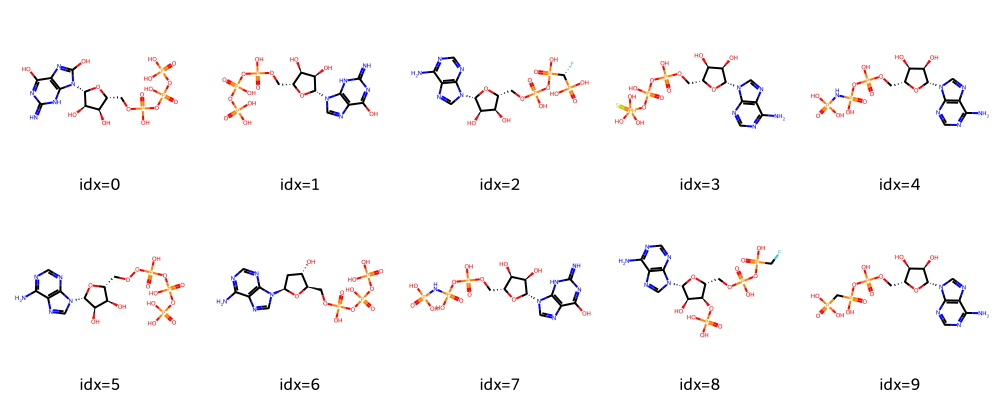

In [87]:
query = """
  FOR d IN drug
    FILTER LIKE(d._key, "GEN:%", true)
    SORT d._id DESC
    LIMIT 10
    RETURN d.smiles
"""

Draw.MolsToGridImage(
  [Chem.MolFromSmiles(smiles) for smiles in db.aql.execute(query)],
  molsPerRow=5,
  legends=[f"idx={i}" for i in range(len(mols))]
)